# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [141]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [4]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',delimiter=';')

# Load in the feature summary fizle.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter=';')

In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [41]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape

(891221, 85)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
#Total Missing Values
azdias.isnull().sum().sum()

4896838

In [9]:
azdias['AGER_TYP'].value_counts()

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

In [10]:
for i in range(azdias.shape[1]):
    attr = feat_info.iloc[i]['attribute']
    col = feat_info.iloc[i]['missing_or_unknown']
    col = col.lstrip('[')
    col = col.rstrip(']')
    col = col.split(",")
    to_change=[]
    for j in col:
        if j!='X' and j!='XX' and j!='':
            to_change.append(int(j))
        else:
            to_change.append(j)
    azdias[attr] = azdias[attr].replace(to_change,np.nan)

In [11]:
azdias['AGER_TYP'].value_counts()

2.0    98472
1.0    79802
3.0    27104
Name: AGER_TYP, dtype: int64

In [12]:
#Missing Values after Converting
azdias.isnull().sum().sum()

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
miss = azdias.isnull().sum()

In [14]:
miss

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

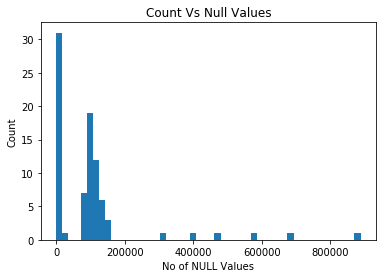

In [15]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(miss,bins=50)
plt.xlabel("No of NULL Values")
plt.ylabel("Count")
plt.title("Count Vs Null Values")
plt.show()

In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
cols_to_remove=[]
for i in azdias.columns:
    if(azdias[i].isnull().sum() > 200000):
        cols_to_remove.append(i)
cols_to_remove 

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [17]:
azdias.drop(cols_to_remove,inplace=True,axis=1)

In [18]:
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

From the Histogram we can infer that most of the data has less than 200000 null values, Therefore columns with null values greater than that can be considered as Outliers, Therefore we remove those Columns.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

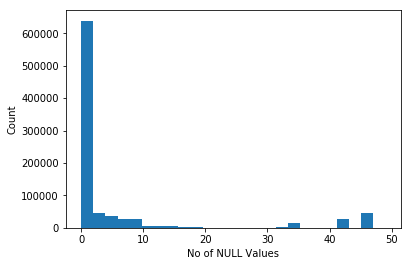

In [19]:
# How much data is missing in each row of the dataset?
nulls_in_rows = azdias.isnull().sum(axis=1)
plt.hist(nulls_in_rows,bins=25)
plt.xlabel("No of NULL Values")
plt.ylabel("Count")
plt.show()

In [20]:
nulls_in_rows.value_counts()

0     623209
47     45578
2      27926
43     27369
8      24592
5      22515
3      17629
1      15738
6      13771
7      13714
4      12607
34     10816
10      5410
15      4743
35      3911
13      3255
9       3042
33      2985
16      2505
14      2243
19      1180
11      1127
12       766
17       677
37       538
45       494
18       428
38       421
41       356
20       349
32       206
44       155
21       150
40       137
23       132
22       129
36        84
39        77
24        69
26        59
25        55
27        24
42        21
29        12
30         6
28         5
31         3
49         2
48         1
dtype: int64

In [21]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

#Threshold = 10

above_thresh = azdias[azdias.isnull().sum(axis=1) > 10]
below_thresh = azdias[azdias.isnull().sum(axis=1) <= 10]

In [22]:
below_thresh

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1.0,1,3.0,3,3,4,1,3,2,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,1,3.0,4,4,2,4,2,2,6,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,2,4.0,2,4,2,3,5,4,1,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0
10,3.0,2,1.0,2,2,5,3,1,5,6,...,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0


In [23]:
cols_zero_miss = []
for i in azdias.columns:
    if(azdias[i].isnull().sum() == 0):
        cols_zero_miss.append(i)
cols_zero_miss = cols_zero_miss[:6]
cols_zero_miss

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER']

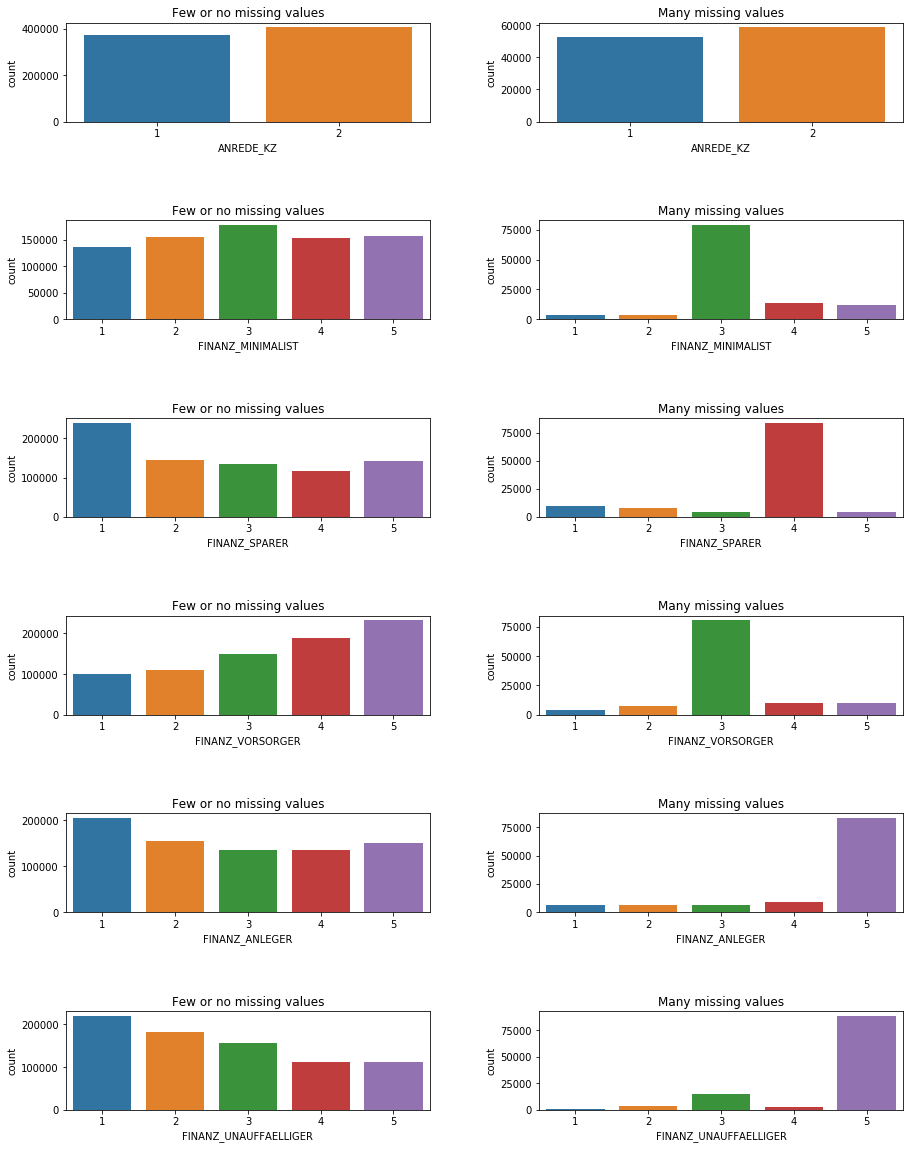

In [24]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
figure, axs = plt.subplots(nrows=len(cols_zero_miss), ncols=2, figsize = (15,20))
figure.subplots_adjust(hspace = 1, wspace=.3)
for i in range(len(cols_zero_miss)):
    sns.countplot(below_thresh[cols_zero_miss[i]], ax=axs[i][0])
    axs[i][0].set_title('Few or no missing values')
    sns.countplot(above_thresh[cols_zero_miss[i]], ax=axs[i][1])
    axs[i][1].set_title('Many missing values')

#### Discussion 1.1.3: Assess Missing Data in Each Row

I have taken Threshold as 10 to seperate rows as above_thresh or below_thresh. This inference was based on the basis of histogram. The Value counts for the first feature is almost the same but for all other 4 features, they vary wildly!!

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [32]:
# How many features are there of each data type?
cols = azdias.columns
clean_feat_info = feat_info[feat_info['attribute'].isin(cols)]
clean_feat_info['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [40]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

binary = []
multi = []

cat_attr = clean_feat_info[clean_feat_info['type']=='categorical']['attribute']

for i in cat_attr:
    counts = len(below_thresh[i].unique())
    if(counts==2):
        binary.append(i)
    elif(counts>2):
        multi.append(i)
binary

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']

In [39]:
for i in binary:
    print("{} : {}".format(i,below_thresh[i].unique()))

ANREDE_KZ : [2 1]
GREEN_AVANTGARDE : [0 1]
SOHO_KZ : [ 1.  0.]
OST_WEST_KZ : ['W' 'O']


In [46]:
below_thresh['OST_WEST_KZ'] = below_thresh['OST_WEST_KZ'].apply(lambda x: 1 if x=='W' else 0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [53]:
clean_df = below_thresh
clean_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [55]:
for i in multi:
    print("{} : {}".format(i,below_thresh[i].unique()))

CJT_GESAMTTYP : [  5.   3.   2.   4.   1.   6.  nan]
FINANZTYP : [1 6 5 2 4 3]
GFK_URLAUBERTYP : [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   7.   2.   6.  nan]
LP_FAMILIE_FEIN : [  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
LP_FAMILIE_GROB : [  3.   1.  nan   5.   2.   4.]
LP_STATUS_FEIN : [  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
LP_STATUS_GROB : [  1.   2.   4.   5.   3.  nan]
NATIONALITAET_KZ : [  1.   3.   2.  nan]
SHOPPER_TYP : [  3.   2.   1.   0.  nan]
VERS_TYP : [  2.   1.  nan]
ZABEOTYP : [5 3 4 1 6 2]
GEBAEUDETYP : [ 8.  1.  3.  2.  6.  4.  5.]
CAMEO_DEUG_2015 : ['8' '4' '2' '6' '1' '9' '5' '7' '3' nan]
CAMEO_DEU_2015 : ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 '9B' '1B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']


In [57]:
# Re-encode categorical variable(s) to be kept in the analysis.
clean_df.drop(multi,inplace=True,axis=1)
clean_df.shape

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(780153, 65)

#### Discussion 1.2.1: Re-Encode Categorical Features

I did the following steps for Re-Encoding Categorical Features

 - Encoded 'OST_WEST_KZ' numerically as 1 and 0 
 - Other binary features were left unchanged
 - Dropped Multi-Level Categorical features

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [62]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
clean_df['decade'] = clean_df['PRAEGENDE_JUGENDJAHRE']
clean_df['movement'] = clean_df['PRAEGENDE_JUGENDJAHRE']
clean_df.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,14.0,14.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,15.0,15.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,8.0,8.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,8.0,8.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,3.0,3.0


In [63]:
decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

In [65]:
clean_df['decade'].replace(decade_dict,inplace=True)
clean_df['movement'].replace(movement_dict,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [67]:
clean_df.sample()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement
221536,4.0,1,4,3,3,4,1,3,0,2.0,...,0.0,0.0,2.0,1.0,1.0,5.0,2.0,5.0,5.0,1.0


In [68]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
clean_df['wealth'] = clean_df['CAMEO_INTL_2015']
clean_df['life_stage'] = clean_df['CAMEO_INTL_2015']

wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [69]:
clean_df['wealth'].replace(wealth_dict,inplace=True)
clean_df['life_stage'].replace(life_stage_dict,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [70]:
clean_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

Out of the 6 mixed features, I created 2 new features decade and movement from 'PRAEGENDE_JUGENDJAHRE' and I also created 2 new features wealth and life_stage from 'CAMEO_INTL_2015'. Now i'll drop all the mixed data type coloumns.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [71]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [77]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
mixed_cols = clean_feat_info[clean_feat_info['type']=='mixed']['attribute']
clean_df.drop(mixed_cols,inplace=True,axis=1)
clean_df.shape

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(780153, 63)

In [78]:
clean_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [79]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    #Convert Missing codes to nan
    for i in range(df.shape[1]):
        attr = feat_info.iloc[i]['attribute']
        col = feat_info.iloc[i]['missing_or_unknown']
        col = col.lstrip('[')
        col = col.rstrip(']')
        col = col.split(",")
        to_change=[]
        for j in col:
            if j!='X' and j!='XX' and j!='':
                to_change.append(int(j))
            else:
                to_change.append(j)
        df[attr] = df[attr].replace(to_change,np.nan)
        
    #Remove Columns with greater than 200000 null values
    cols_to_remove=[]
    for i in df.columns:
        if(df[i].isnull().sum() > 200000):
            cols_to_remove.append(i)
    df.drop(cols_to_remove,inplace=True,axis=1)
    
    #Remove rows with greater than 10 null values
    df = df[df.isnull().sum(axis=1) <= 10]
    
    #ReEncode One speacial Binary Feature and drop all multi-level binary features
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].apply(lambda x: 1 if x=='W' else 0)
    df.drop(multi,inplace=True,axis=1)
    
    #Take Care of Mixed Type Features
    df['decade'] = df['PRAEGENDE_JUGENDJAHRE']
    df['movement'] = df['PRAEGENDE_JUGENDJAHRE']
    decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    df['decade'].replace(decade_dict,inplace=True)
    df['movement'].replace(movement_dict,inplace=True)
    
    df['wealth'] = df['CAMEO_INTL_2015']
    df['life_stage'] = df['CAMEO_INTL_2015']
    wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

    life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                       '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                       '51':1, '52':2, '53':3, '54':4, '55':5}
    df['wealth'].replace(wealth_dict,inplace=True)
    df['life_stage'].replace(life_stage_dict,inplace=True)
    
    #Drop all mixed features
    mixed_cols = clean_feat_info[clean_feat_info['type']=='mixed']['attribute']
    df.drop(mixed_cols,inplace=True,axis=1)
    
    #return clean DF
    return df


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [92]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
fill_missing = Imputer(strategy='most_frequent')
final_df = pd.DataFrame(fill_missing.fit_transform(clean_df))
final_df.columns = clean_df.columns
final_df.index = clean_df.index

In [94]:
final_df.head()
final_df.isnull().sum().sum()

0

In [95]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(final_df)
final_df_scaled = pd.DataFrame(scaled_df, columns=list(final_df))
final_df_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
0,-1.767651,0.958395,-1.488140,1.539080,-1.045251,1.467273,0.980071,1.326876,-0.531199,1.006277,...,0.422909,1.435790,0.563767,-0.179002,-0.132852,0.679557,1.105284,0.531199,1.170995,-1.249732
1,0.198089,0.958395,-1.488140,0.866538,-1.771610,-0.569041,0.262544,1.326876,1.882535,1.006277,...,-0.952555,0.405449,0.563767,-0.179002,-0.132852,-0.795517,1.105284,-1.882535,-0.874275,0.763856
2,1.180959,0.958395,0.688928,-0.478545,1.133828,-0.569041,-1.172510,-0.817895,-0.531199,-0.316158,...,-0.952555,-0.624893,0.563767,-1.182990,-1.003725,-0.057980,-0.259737,0.531199,-1.556031,-0.578536
3,0.198089,-1.043411,0.688928,0.193996,0.407468,-1.247812,0.262544,-0.817895,-0.531199,1.006277,...,0.422909,-0.624893,-0.339941,0.824987,0.302585,1.417095,-0.259737,0.531199,0.489238,0.092660
4,-1.767651,0.958395,-0.036761,-1.151087,1.133828,-0.569041,-0.454983,1.326876,-0.531199,1.006277,...,0.422909,1.435790,1.467476,-1.182990,-1.003725,-0.057980,-1.624758,0.531199,1.170995,0.763856


### Discussion 2.1: Apply Feature Scaling

First of all, I imputed all of the null values with the **most frequent values** of that feature. In the next step StandardScaler was used to scale our dataset for PCA.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [96]:
# Apply PCA to the data.
pca = PCA()
pca.fit(final_df_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

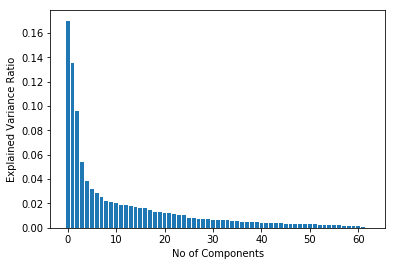

In [99]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_)
plt.xlabel("No of Components")
plt.ylabel("Explained Variance Ratio")
plt.show()

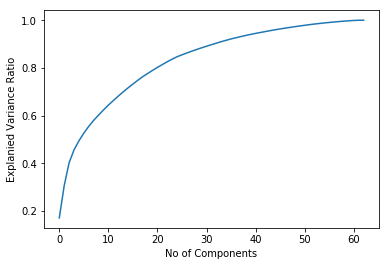

In [101]:
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
plt.xlabel("No of Components")
plt.ylabel("Explanied Variance Ratio")
plt.show()

In [102]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_final = PCA(n_components=30)
df_pca = pca_final.fit_transform(final_df_scaled)

In [107]:
pca_final.components_.shape

(30, 63)

### Discussion 2.2: Perform Dimensionality Reduction
From the graph, at about 30 components we are abe to achieve 88% Explained Variance Ratio, Therefore i would go with 30 components

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [113]:
df_temp = pd.DataFrame(pca.components_,columns = final_df_scaled.columns)
df_temp.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
0,-0.124231,0.007500,-0.222240,0.151790,-0.119290,0.073993,0.080668,0.160641,-0.111012,0.039110,...,0.217466,0.041582,-0.166573,0.142362,0.196076,0.134485,0.111353,0.111012,0.205226,-0.125191
1,0.257121,0.093115,0.061197,-0.232251,0.229373,-0.203554,-0.225295,0.119688,-0.017460,-0.058983,...,0.094266,0.013992,-0.076201,0.070536,0.095544,0.068165,-0.239491,0.017460,0.078240,-0.001297
2,0.079634,-0.367797,0.155329,-0.106638,0.101084,-0.190735,-0.100143,-0.042388,0.048625,-0.030441,...,0.048558,0.004906,-0.041013,0.036725,0.050253,0.033839,-0.111211,-0.048625,0.029313,-0.009977
3,-0.047060,0.038886,0.062308,-0.001938,-0.018406,-0.123262,0.081236,-0.102862,0.398746,0.002376,...,0.080982,0.137029,0.034393,0.051601,0.247108,0.095741,0.030799,-0.398746,-0.122600,0.060793
4,-0.001080,0.008210,0.087327,-0.007851,-0.061057,0.039253,-0.050678,-0.089143,0.058623,0.000886,...,0.022650,-0.485122,-0.402374,0.220573,0.091599,0.149183,0.019183,-0.058623,-0.005599,0.022229


In [116]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def find_weights(pca,c):
    df = pd.DataFrame(pca.components_,columns = final_df_scaled.columns)
    weights = df.iloc[c].sort_values(ascending=False)
    return weights

In [117]:
w1 = find_weights(pca_final,0)
w1

PLZ8_ANTG3               0.225309
PLZ8_ANTG4               0.217466
wealth                   0.205226
HH_EINKOMMEN_SCORE       0.202928
ORTSGR_KLS9              0.196076
EWDICHTE                 0.193928
FINANZ_HAUSBAUER         0.160641
KBA05_ANTG4              0.153603
PLZ8_ANTG2               0.153328
FINANZ_SPARER            0.151790
ARBEIT                   0.142362
KBA05_ANTG3              0.136597
ANZ_HAUSHALTE_AKTIV      0.135607
RELAT_AB                 0.134485
SEMIO_PFLICHT            0.119908
SEMIO_REL                0.117353
decade                   0.111353
movement                 0.111012
SEMIO_RAT                0.099003
SEMIO_TRADV              0.092826
SEMIO_MAT                0.083109
FINANZ_UNAUFFAELLIGER    0.080668
SEMIO_FAM                0.080647
SEMIO_KULT               0.074925
FINANZ_ANLEGER           0.073993
REGIOTYP                 0.060860
SEMIO_SOZ                0.042536
PLZ8_HHZ                 0.041582
KKK                      0.039730
SEMIO_KAEM    

In [118]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
w2 = find_weights(pca_final,1)
w2

ALTERSKATEGORIE_GROB     0.257121
SEMIO_ERL                0.230309
FINANZ_VORSORGER         0.229373
SEMIO_LUST               0.179719
RETOURTYP_BK_S           0.162453
FINANZ_HAUSBAUER         0.119688
SEMIO_KRIT               0.118655
SEMIO_KAEM               0.115770
W_KEIT_KIND_HH           0.113791
PLZ8_ANTG3               0.099446
EWDICHTE                 0.096724
ORTSGR_KLS9              0.095544
PLZ8_ANTG4               0.094266
ANREDE_KZ                0.093115
wealth                   0.078240
KBA05_ANTG4              0.074172
SEMIO_DOM                0.072690
ARBEIT                   0.070536
PLZ8_ANTG2               0.068529
RELAT_AB                 0.068165
ANZ_HAUSHALTE_AKTIV      0.065199
FINANZ_MINIMALIST        0.061197
HH_EINKOMMEN_SCORE       0.058966
WOHNDAUER_2008           0.057280
KBA05_ANTG3              0.049044
ANZ_HH_TITEL             0.031762
movement                 0.017460
PLZ8_HHZ                 0.013992
REGIOTYP                 0.013380
ANZ_TITEL     

In [119]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
w3 = find_weights(pca_final,2)
w3

SEMIO_VERT               0.345927
SEMIO_SOZ                0.262867
SEMIO_FAM                0.248971
SEMIO_KULT               0.232832
FINANZ_MINIMALIST        0.155329
RETOURTYP_BK_S           0.109388
FINANZ_VORSORGER         0.101084
W_KEIT_KIND_HH           0.084987
ALTERSKATEGORIE_GROB     0.079634
SEMIO_REL                0.068361
SEMIO_LUST               0.064293
SEMIO_MAT                0.055094
ORTSGR_KLS9              0.050253
EWDICHTE                 0.049536
PLZ8_ANTG3               0.048846
GREEN_AVANTGARDE         0.048625
PLZ8_ANTG4               0.048558
ARBEIT                   0.036725
RELAT_AB                 0.033840
PLZ8_ANTG2               0.032800
WOHNDAUER_2008           0.032495
KBA05_ANTG4              0.029551
wealth                   0.029313
ANZ_HAUSHALTE_AKTIV      0.026439
ANZ_HH_TITEL             0.013835
KBA05_ANTG3              0.010852
ANZ_TITEL                0.009845
PLZ8_HHZ                 0.004906
SOHO_KZ                  0.000108
REGIOTYP      

### Discussion 2.3: Interpret Principal Components

From the first Principal Component ,we can infer the following details: 

 - PLZ8_ANTG3, PLZ8_ANTG4, wealth are the top 3 features in terms of weights. This means the share of 10+ family homes and the share of 6-10 family homes tend to increase together.
 - MOBI_REGIO and PLZ8_ANTG1 have a negative correlation. It means that when the share of 1-2 family homes in a macro-cell increases, it tends to have higher movements.
 
Similarly we can infer similar details from the other components!

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [124]:
def k_mean_score(df,n):
    model = KMeans(n_clusters=n)
    model.fit(df)
    score = model.score(df)
    return abs(score)

#print(k_mean_score(df_pca,2))

37181212.862


In [129]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
scores=[]
for i in range(1,21):
    s = k_mean_score(df_pca,i)
    print("Score with {} clusters is {}".format(i,s))
    scores.append(s)

Score with 1 clusters is 43446114.47138867
Score with 2 clusters is 37181211.17113877
Score with 3 clusters is 33956017.75051591
Score with 4 clusters is 31926454.897468764
Score with 5 clusters is 30509491.90348866
Score with 6 clusters is 29262427.01547916
Score with 7 clusters is 28161941.863848682
Score with 8 clusters is 27329661.341606855
Score with 9 clusters is 26741829.015835043
Score with 10 clusters is 26173218.452951655
Score with 11 clusters is 25580612.76772926
Score with 12 clusters is 25107031.360097464
Score with 13 clusters is 24721651.574616853
Score with 14 clusters is 24444811.946703397
Score with 15 clusters is 24135998.157757666
Score with 16 clusters is 23781528.86625591
Score with 17 clusters is 23224398.39621369
Score with 18 clusters is 23050471.313632935
Score with 19 clusters is 22845659.18851641
Score with 20 clusters is 22426026.07241341


In [130]:
scores

[43446114.471388668,
 37181211.171138771,
 33956017.750515908,
 31926454.897468764,
 30509491.903488658,
 29262427.015479159,
 28161941.863848682,
 27329661.341606855,
 26741829.015835043,
 26173218.452951655,
 25580612.76772926,
 25107031.360097464,
 24721651.574616853,
 24444811.946703397,
 24135998.157757666,
 23781528.866255909,
 23224398.396213692,
 23050471.313632935,
 22845659.188516408,
 22426026.072413411]

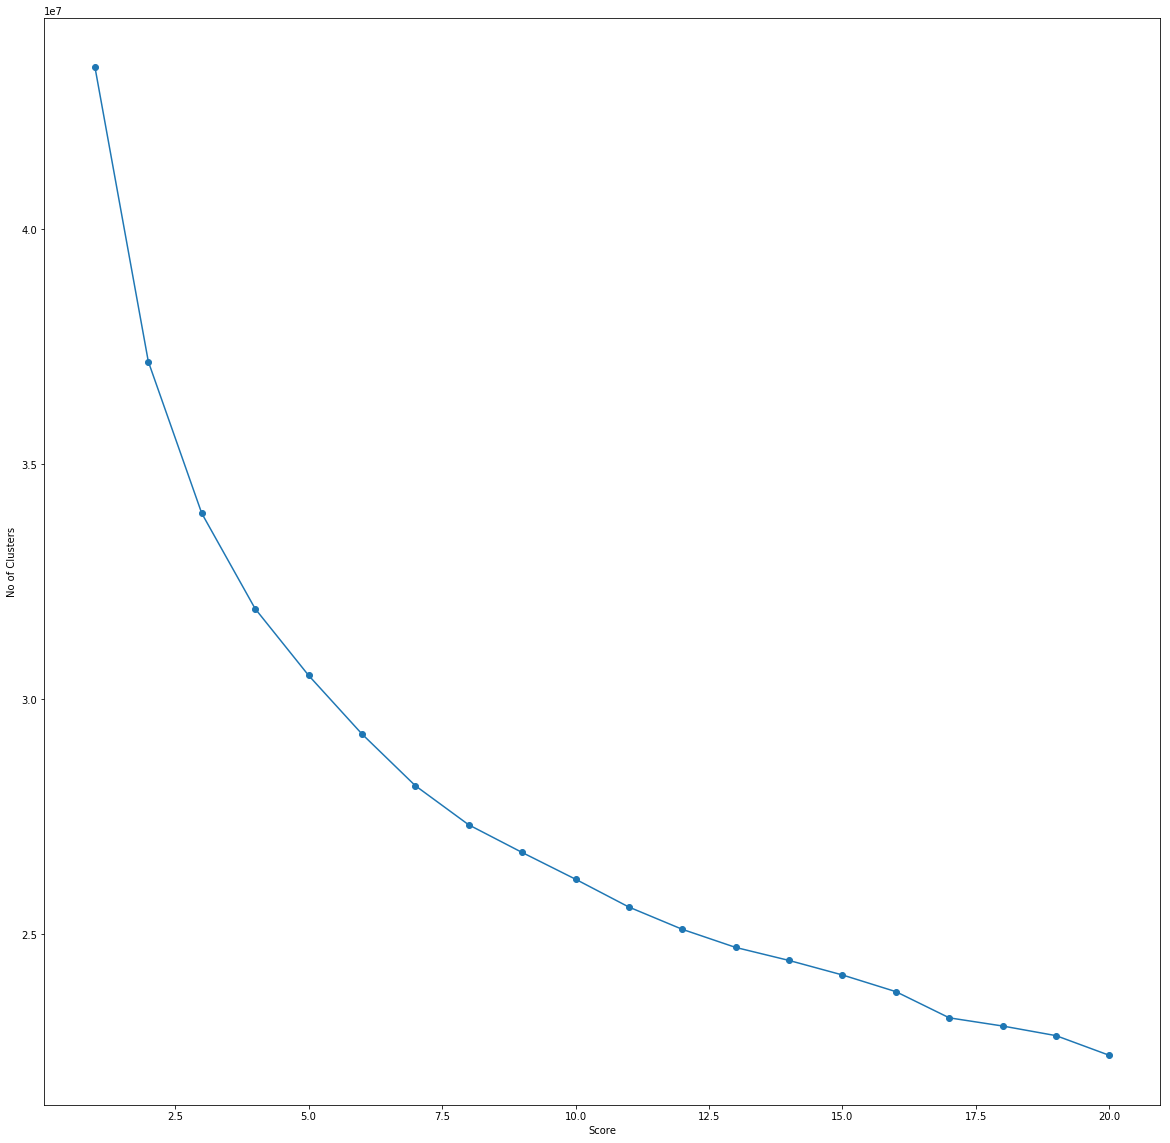

In [133]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
x_axis = [i for i in range(1,21)]
plt.figure(figsize=(20,20))
plt.plot(x_axis,scores,linestyle='-', marker='o')
plt.ylabel("No of Clusters")
plt.xlabel("Score")
plt.show()

In [134]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 17)
final_model = kmeans.fit(df_pca)
df_pred = final_model.predict(df_pca)

In [135]:
df_pred

array([13,  0,  1, ..., 11,  2,  3], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

From the plot, I feel 17 cluster is our elbow point. Therefore I am going to use 17 clusters for this dataset!

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [142]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [143]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [144]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

#Data Cleaning
clean_cust = clean_data(customers)

In [161]:
clean_cust.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
0,2.0,4.0,1,5,1,5,1,2,2,NaN,...,0.0,5.0,5.0,1.0,2.0,1.0,2.0,0.0,1.0,3.0
2,NaN,4.0,2,5,1,5,1,4,4,NaN,...,1.0,3.0,2.0,3.0,5.0,3.0,2.0,0.0,3.0,4.0
3,1.0,4.0,1,5,1,5,2,1,2,NaN,...,0.0,3.0,4.0,1.0,3.0,1.0,1.0,1.0,2.0,4.0
4,NaN,3.0,1,3,1,4,4,5,2,1960.0,...,1.0,3.0,3.0,3.0,5.0,1.0,4.0,1.0,4.0,1.0
5,1.0,3.0,1,5,1,5,1,2,3,NaN,...,1.0,5.0,5.0,3.0,7.0,5.0,2.0,0.0,3.0,4.0


In [146]:
#Filling Missing Values
cust_df_imp = pd.DataFrame(fill_missing.fit_transform(clean_cust))
cust_df_imp.columns = clean_cust.columns
cust_df_imp.index = clean_cust.index

In [149]:
#Scaling Our Dataset
scaled_df = scaler.fit_transform(cust_df_imp)
cust_scaled = pd.DataFrame(scaled_df, columns=list(cust_df_imp))
cust_scaled.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
0,0.434849,0.695183,-0.699743,0.717376,-0.503859,0.501757,-0.591425,0.191844,-0.576267,-0.450601,...,-0.845274,1.468567,1.371656,-1.815558,-1.446874,-1.340838,-0.640433,-0.975635,-1.130991,-0.281855
1,0.434849,0.695183,1.429096,0.717376,-0.503859,0.501757,-0.591425,2.311687,0.952090,-0.450601,...,0.723564,-0.677904,-1.605743,0.172099,-0.055299,0.069538,-0.640433,-0.975635,0.289446,0.465215
2,-1.394443,0.695183,-0.699743,0.717376,-0.503859,0.501757,0.426121,-0.868077,-0.576267,-0.450601,...,-0.845274,-0.677904,0.379189,-1.815558,-0.983016,-1.340838,-1.390521,1.024973,-0.420773,0.465215
3,0.434849,-0.701638,-0.699743,-1.263350,-0.503859,-0.707897,2.461213,3.371609,-0.576267,1.028754,...,0.723564,-0.677904,-0.613277,0.172099,-0.055299,-1.340838,0.859741,1.024973,0.999665,-1.775993
4,-1.394443,-0.701638,-0.699743,0.717376,-0.503859,0.501757,-0.591425,0.191844,0.187911,-0.450601,...,0.723564,1.468567,1.371656,0.172099,0.872417,1.479914,-0.640433,-0.975635,0.289446,0.465215


In [150]:
#Applying PCA
cust_pca = pca_final.fit_transform(cust_scaled)

#Applying KMeans
cust_pred = final_model.predict(cust_pca)

In [158]:
cust_pred

array([ 6, 12,  0, ..., 11,  8,  7], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'General Clusters')

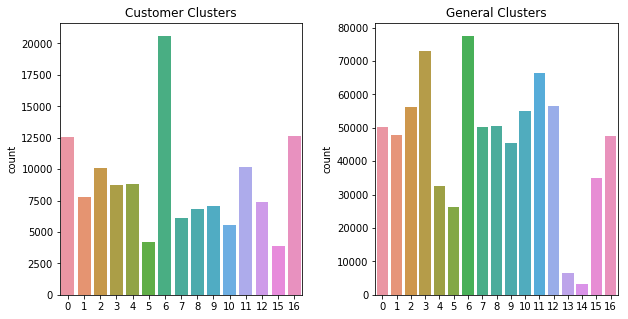

In [159]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust(hspace = 1, wspace=.3)
sns.countplot(cust_pred, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(df_pred, ax=axs[1])
axs[1].set_title('General Clusters')

Now we need to find the percentage for each cluster, to compare properly

In [168]:
#Finding Percentage of each cluster for each of the data
cust_perc = []
pop_perc = []
for i in range(1,18):
    cust_perc.append((list(cust_pred).count(i)/len(cust_pred))*100)
    pop_perc.append((list(df_pred).count(i)/len(df_pred))*100)

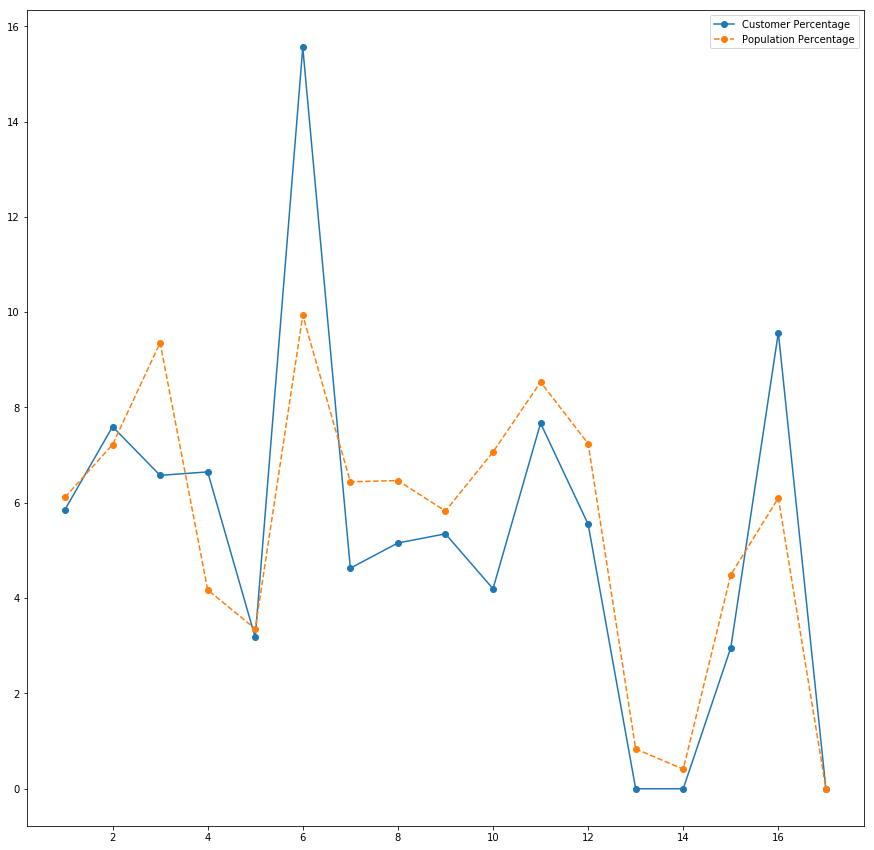

In [179]:
#Plot to compare visually
x = [i for i in range(1,18)]
plt.figure(figsize=(15,15))
plt.plot(x,cust_perc,label='Customer Percentage',marker='o')
plt.plot(x,pop_perc,label = 'Population Percentage',marker='o',linestyle='dashed')
plt.legend()
plt.show()

In [180]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
pca_inverse1 = pca_final.inverse_transform(final_model.cluster_centers_[6])
inv1 = scaler.inverse_transform(pca_inverse1)
over_represented = pd.Series(data = inv1, index = clean_cust.columns)

In [181]:
over_represented

AGER_TYP                    1.622219
ALTERSKATEGORIE_GROB        3.402376
ANREDE_KZ                   0.940970
FINANZ_MINIMALIST           5.258369
FINANZ_SPARER               1.459918
FINANZ_VORSORGER            4.474732
FINANZ_ANLEGER              1.346709
FINANZ_UNAUFFAELLIGER       2.174065
FINANZ_HAUSBAUER            1.424208
GEBURTSJAHR              1948.734239
GREEN_AVANTGARDE            1.018206
HEALTH_TYP                  1.913186
RETOURTYP_BK_S              4.151580
SEMIO_SOZ                   5.140709
SEMIO_FAM                   4.787705
SEMIO_REL                   4.034951
SEMIO_MAT                   4.622203
SEMIO_VERT                  6.546520
SEMIO_LUST                  5.591644
SEMIO_ERL                   3.476144
SEMIO_KULT                  5.282759
SEMIO_RAT                   2.843544
SEMIO_KRIT                  2.698503
SEMIO_DOM                   3.325225
SEMIO_KAEM                  2.041686
SEMIO_PFLICHT               3.175518
SEMIO_TRADV                 3.372465
S

In [182]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
pca_inverse2 = pca_final.inverse_transform(final_model.cluster_centers_[3])
inv2 = scaler.inverse_transform(pca_inverse2)
under_represented = pd.Series(data = inv2, index = clean_cust.columns)

In [183]:
under_represented

AGER_TYP                    1.967296
ALTERSKATEGORIE_GROB        2.868633
ANREDE_KZ                   1.099495
FINANZ_MINIMALIST           4.062562
FINANZ_SPARER               1.832006
FINANZ_VORSORGER            4.150593
FINANZ_ANLEGER              1.708358
FINANZ_UNAUFFAELLIGER       2.149545
FINANZ_HAUSBAUER            2.609052
GEBURTSJAHR              1951.983317
GREEN_AVANTGARDE            0.564321
HEALTH_TYP                  2.330564
RETOURTYP_BK_S              4.164981
SEMIO_SOZ                   4.936964
SEMIO_FAM                   5.030838
SEMIO_REL                   4.349526
SEMIO_MAT                   4.335718
SEMIO_VERT                  5.725036
SEMIO_LUST                  4.579755
SEMIO_ERL                   3.805167
SEMIO_KULT                  5.305392
SEMIO_RAT                   3.578590
SEMIO_KRIT                  3.290710
SEMIO_DOM                   3.908952
SEMIO_KAEM                  3.170900
SEMIO_PFLICHT               4.101279
SEMIO_TRADV                 3.910481
S

### Discussion 3.3: Compare Customer Data to Demographics Data

According to the above Analysis, 

Cluster 6 is overrepresented in customers data if compared to general popultation data. Some characteristics of the group of population that are relative popular with the mail-order company:

 - in areas where their is average share of 3-5 family homes(PLZ8_ANTG2=2.66)
 - in areas where size of community is almost 20,000 inhabitants(ORTSGR_KLS9 = 4.99)
 - in areas where society belongs to upper class(REGIOTYP = 2.77)
 
Cluster 3 is underrepresented in customers data if compared to general population data. Some characteristics of the segment of the population that are relatively unpopular with the company:

 - in areas where their is high share of 3-5 family homes(PLZ8_ANTG2=3.08)
 - in areas where size of community is somewhere in between of 50,001 to 100,000 inhabitants(ORTSGR_KLS9 = 6.67)
 - in areas where society belongs to middle class(REGIOTYP = 4.76)


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.